# 1. What's that?

After getting the data from Market Watch, the indexes have to be preprocessed to format available to train by Temporal Fusion Transformers.

In this script the datasets are:

a) Loaded

b) Preprocessed & merged

c) Visualized

d) Summarized

e) Enriched with date-related categories

f) Supplemented by extra operations (in search of the correct form of the output file)

g) Written to the file

# 2. Data load

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import missingno
import copy

In [2]:
datasets_names = ["SP500", "Gold", "EURUSD"]
datasets_n = len(datasets_names)

In [3]:
datasets = [None] * datasets_n
for dt_idx, dt_name in enumerate(datasets_names):
    datasets[dt_idx] = pd.DataFrame(columns=["Date", "Open", "High", "Low", "Close"])
    for csv_no in range(10):
        datasets[dt_idx] = pd.concat([datasets[dt_idx], pd.read_csv(dt_name + "/" + str(csv_no+1) + '.csv',
                                                        thousands=',')])

In [4]:
datasets[0]

,Date,Open,High,Low,Close
0,04/01/2013,1569.18,1570.57,1558.47,1562.17
1,03/28/2013,1562.86,1570.28,1561.08,1569.19
2,03/27/2013,1563.75,1564.07,1551.90,1562.85
3,03/26/2013,1551.69,1563.95,1551.69,1563.77
4,03/25/2013,1556.89,1564.91,1546.22,1551.69
...,...,...,...,...,...
248,04/09/2021,4096.11,4129.48,4095.51,4128.80
249,04/08/2021,4089.95,4098.19,4082.54,4097.17
250,04/07/2021,4074.29,4083.13,4068.31,4079.95
251,04/06/2021,4075.57,4086.23,4068.14,4073.94


In [5]:
datasets[1].describe()

,Open,High,Low,Close
count,2518.000000,2518.000000,2518.000000,2518.000000
mean,1431.339237,1441.190905,1420.711358,1431.089833
std,247.109549,249.286544,244.257420,247.023120
min,1051.500000,1062.700000,1045.400000,1049.600000
25%,1243.825000,1251.750000,1235.800000,1244.225000
50%,1319.750000,1326.950000,1310.950000,1319.100000
75%,1655.975000,1666.400000,1640.425000,1655.125000
max,2076.400000,2089.200000,2049.000000,2069.400000


# 3. Preprocessing & merging

In [6]:
dates_analyzed = pd.date_range(start='2012-04-02', end='2022-04-01') # no data for SP500 before 2013-04-02
dates_analyzed = pd.DataFrame(dates_analyzed, columns=["Date"])
dates_analyzed["Date"] = dates_analyzed["Date"].dt.strftime('%m/%d/%Y')
dates_analyzed.head()

,Date
0,04/02/2012
1,04/03/2012
2,04/04/2012
3,04/05/2012
4,04/06/2012


In [7]:
datasets[2]

,Date,Open,High,Low,Close
0,04/01/2013,1.2820,1.2850,1.2820,1.2850
1,03/29/2013,1.2819,1.2820,1.2819,1.2820
2,03/28/2013,1.2781,1.2819,1.2781,1.2819
3,03/27/2013,1.2862,1.2862,1.2781,1.2781
4,03/26/2013,1.2854,1.2862,1.2854,1.2862
...,...,...,...,...,...
256,04/08/2021,1.1869,1.1928,1.1861,1.1918
257,04/07/2021,1.1873,1.1916,1.1861,1.1873
258,04/06/2021,1.1815,1.1880,1.1796,1.1874
259,04/05/2021,1.1765,1.1822,1.1738,1.1813


In [8]:
datasets = [dates_analyzed.merge(datasets[i], on="Date", how="left") for i in range(datasets_n)]
datasets[0]

,Date,Open,High,Low,Close
0,04/02/2012,1408.47,1422.38,1404.46,1419.04
1,04/03/2012,1418.98,1419.00,1404.62,1413.38
2,04/04/2012,1413.09,1413.09,1394.09,1398.96
3,04/05/2012,1398.79,1401.60,1392.92,1398.08
4,04/06/2012,NaN,NaN,NaN,NaN
...,...,...,...,...,...
3647,03/28/2022,4541.09,4575.65,4517.69,4575.52
3648,03/29/2022,4602.86,4637.30,4589.66,4631.60
3649,03/30/2022,4624.20,4627.77,4581.32,4602.45
3650,03/31/2022,4599.02,4603.07,4530.41,4530.41


In [9]:
datasets_merged = pd.concat([datasets[i] for i in range(datasets_n)], axis=1)
datasets_merged = datasets_merged.T.drop_duplicates().T
column_names = ["Open", "High", "Low", "Close"]
merged_column_names_tmp = [col_name + "_" + datasets_names[i] for i in range(datasets_n) for col_name in column_names]
merged_column_names = ["Date"]
merged_column_names.extend(merged_column_names_tmp)
datasets_merged.columns = merged_column_names

In [10]:
datasets_merged["Date"] = pd.to_datetime(datasets_merged['Date'], errors='coerce')
datasets_merged["Date"] = pd.to_datetime(datasets_merged['Date'].dt.strftime('%Y/%m/%d'))

In [11]:
for col in datasets_merged.columns:
    if col != "Date":
        datasets_merged[col] = datasets_merged[col].astype(float)

In [12]:
datasets_merged.tail()

,Date,Open_SP500,High_SP500,Low_SP500,Close_SP500,Open_Gold,High_Gold,Low_Gold,Close_Gold,Open_EURUSD,High_EURUSD,Low_EURUSD,Close_EURUSD
3647,2022-03-28,4541.09,4575.65,4517.69,4575.52,1958.7,1959.8,1915.7,1939.8,1.0985,1.1001,1.0945,1.0988
3648,2022-03-29,4602.86,4637.30,4589.66,4631.60,1922.4,1929.4,1888.3,1912.2,1.0984,1.1139,1.0971,1.1088
3649,2022-03-30,4624.20,4627.77,4581.32,4602.45,1924.0,1943.4,1920.1,1939.0,1.1087,1.1172,1.1083,1.1161
3650,2022-03-31,4599.02,4603.07,4530.41,4530.41,1937.3,1955.0,1923.0,1954.0,1.1160,1.1186,1.1061,1.1067
3651,2022-04-01,4540.32,4548.70,4507.57,4545.86,1942.4,1944.5,1921.4,1923.7,1.1068,1.1078,1.1028,1.1046


# 4. Visualization

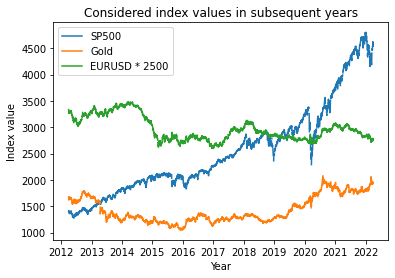

In [13]:
for dataset_name in datasets_names:
    x = datasets_merged["Date"]
    y = copy.deepcopy(datasets_merged["Open_" + dataset_name])
    label = dataset_name
    if dataset_name == "EURUSD":
        y *= 2500
        label += (" * 2500")
    plt.plot(x, y, label=label)
plt.title("Considered index values in subsequent years")
plt.xlabel("Year")
plt.ylabel("Index value")
plt.legend()
plt.show()

# 5. Summaries

In [14]:
datasets_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3652 entries, 0 to 3651
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3652 non-null   datetime64[ns]
 1   Open_SP500    2518 non-null   float64       
 2   High_SP500    2518 non-null   float64       
 3   Low_SP500     2518 non-null   float64       
 4   Close_SP500   2518 non-null   float64       
 5   Open_Gold     2518 non-null   float64       
 6   High_Gold     2518 non-null   float64       
 7   Low_Gold      2518 non-null   float64       
 8   Close_Gold    2518 non-null   float64       
 9   Open_EURUSD   2610 non-null   float64       
 10  High_EURUSD   2610 non-null   float64       
 11  Low_EURUSD    2610 non-null   float64       
 12  Close_EURUSD  2610 non-null   float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 528.5 KB


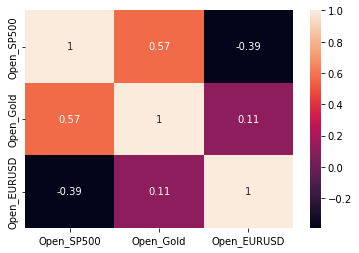

In [15]:
correlation_matrix = datasets_merged.drop("Date", axis=1)
correlation_matrix = correlation_matrix[["Open_SP500", "Open_Gold", "Open_EURUSD"]].corr()
sn.heatmap(correlation_matrix, annot=True)
plt.show()

In [16]:
datasets_merged.describe()

,Open_SP500,High_SP500,Low_SP500,Close_SP500,Open_Gold,High_Gold,Low_Gold,Close_Gold,Open_EURUSD,High_EURUSD,Low_EURUSD,Close_EURUSD
count,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2610.000000,2610.000000,2610.000000,2610.000000
mean,2549.086223,2561.864492,2535.265592,2549.604805,1431.339237,1441.190905,1420.711358,1431.089833,1.186994,1.190683,1.183280,1.186873
std,862.721944,867.704542,857.258690,862.832840,247.109549,249.286544,244.257420,247.023120,0.090709,0.089774,0.091581,0.090705
min,1277.820000,1282.550000,1266.740000,1278.040000,1051.500000,1062.700000,1045.400000,1049.600000,1.038900,1.041900,1.034200,1.038800
25%,1950.452500,1962.510000,1939.215000,1951.165000,1243.825000,1251.750000,1235.800000,1244.225000,1.117700,1.121800,1.113225,1.117325
50%,2365.655000,2372.315000,2353.740000,2364.340000,1319.750000,1326.950000,1310.950000,1319.100000,1.163850,1.167500,1.159700,1.163700
75%,2931.502500,2945.740000,2918.567500,2936.755000,1655.975000,1666.400000,1640.425000,1655.125000,1.246950,1.251025,1.242075,1.246700
max,4804.510000,4818.620000,4780.040000,4796.560000,2076.400000,2089.200000,2049.000000,2069.400000,1.393500,1.393500,1.392300,1.393500


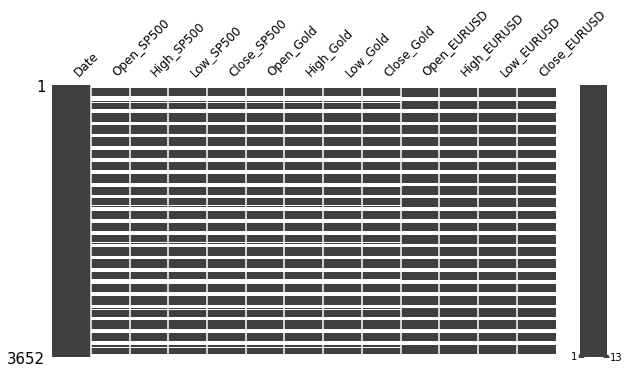

In [17]:
missingno.matrix(datasets_merged, figsize=(10,5), fontsize=12);

# 6. Extra time features

In [18]:
date_dimension = pd.read_csv("date_dimension.csv", sep=';').drop("Date", axis=1)
date_dimension

,Day,Weekday,Is_weekend,Is_holiday,Week_of_month,Week_of_year,Month,Quarter,Year
0,2,2,0,0,1,14,4,2,2012
1,3,3,0,0,1,14,4,2,2012
2,4,4,0,0,1,14,4,2,2012
3,5,5,0,0,1,14,4,2,2012
4,6,6,0,0,1,14,4,2,2012
...,...,...,...,...,...,...,...,...,...
3647,28,2,0,0,5,14,3,1,2022
3648,29,3,0,0,5,14,3,1,2022
3649,30,4,0,0,5,14,3,1,2022
3650,31,5,0,0,5,14,3,1,2022


In [19]:
datasets_merged = pd.concat([datasets_merged, date_dimension], axis=1)
datasets_merged.tail()

,Date,Open_SP500,High_SP500,Low_SP500,Close_SP500,Open_Gold,High_Gold,Low_Gold,Close_Gold,Open_EURUSD,...,Close_EURUSD,Day,Weekday,Is_weekend,Is_holiday,Week_of_month,Week_of_year,Month,Quarter,Year
3647,2022-03-28,4541.09,4575.65,4517.69,4575.52,1958.7,1959.8,1915.7,1939.8,1.0985,...,1.0988,28,2,0,0,5,14,3,1,2022
3648,2022-03-29,4602.86,4637.30,4589.66,4631.60,1922.4,1929.4,1888.3,1912.2,1.0984,...,1.1088,29,3,0,0,5,14,3,1,2022
3649,2022-03-30,4624.20,4627.77,4581.32,4602.45,1924.0,1943.4,1920.1,1939.0,1.1087,...,1.1161,30,4,0,0,5,14,3,1,2022
3650,2022-03-31,4599.02,4603.07,4530.41,4530.41,1937.3,1955.0,1923.0,1954.0,1.1160,...,1.1067,31,5,0,0,5,14,3,1,2022
3651,2022-04-01,4540.32,4548.70,4507.57,4545.86,1942.4,1944.5,1921.4,1923.7,1.1068,...,1.1046,1,6,0,0,1,14,4,2,2022


# 7. Experimental operations (searching for the proper solution)

In [20]:
# datasets_merged = datasets_merged.dropna().reset_index()
datasets_merged["Country"] = 'USA'

# 8. Index column add

In [21]:
idx_df = pd.DataFrame(range(1, len(datasets_merged) + 1))
idx_df.columns = ["Days_from_start"]
datasets_merged = pd.concat([idx_df, datasets_merged], axis=1)
datasets_merged.head(20)

,Days_from_start,Date,Open_SP500,High_SP500,Low_SP500,Close_SP500,Open_Gold,High_Gold,Low_Gold,Close_Gold,...,Day,Weekday,Is_weekend,Is_holiday,Week_of_month,Week_of_year,Month,Quarter,Year,Country
0,1,2012-04-02,1408.47,1422.38,1404.46,1419.04,1671.5,1685.4,1664.4,1679.7,...,2,2,0,0,1,14,4,2,2012,USA
1,2,2012-04-03,1418.98,1419.00,1404.62,1413.38,1678.6,1682.7,1640.2,1672.0,...,3,3,0,0,1,14,4,2,2012,USA
2,3,2012-04-04,1413.09,1413.09,1394.09,1398.96,1645.8,1649.5,1613.0,1614.1,...,4,4,0,0,1,14,4,2,2012,USA
3,4,2012-04-05,1398.79,1401.60,1392.92,1398.08,1622.0,1634.8,1620.7,1630.1,...,5,5,0,0,1,14,4,2,2012,USA
4,5,2012-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6,6,0,0,1,14,4,2,2012,USA
5,6,2012-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7,7,1,0,1,14,4,2,2012,USA
6,7,2012-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8,1,1,0,2,15,4,2,2012,USA
7,8,2012-04-09,1397.45,1397.45,1378.24,1382.20,1641.0,1649.9,1636.7,1643.9,...,9,2,0,0,2,15,4,2,2012,USA
8,9,2012-04-10,1382.18,1383.01,1357.38,1358.59,1643.0,1664.8,1632.5,1660.7,...,10,3,0,0,2,15,4,2,2012,USA
9,10,2012-04-11,1358.98,1374.71,1358.98,1368.71,1660.7,1663.9,1653.5,1660.3,...,11,4,0,0,2,15,4,2,2012,USA


# 9. CSV file write

In [22]:
datasets_merged.to_csv("../data/economy/economy_manual.csv", index=True)